# Symbolic Fuzzing

One of the problems with traditional methods of fuzzing is that they fail to penetrate deeply into the program. Quite often the execution of a specific branch of execution may happen only with very specific inputs, which could represent an extremely small fraction of the input space. The traditional fuzzing methods relies on chance to produce inputs they need. However, relying on randomness to generate values that we want is a bad idea when the space to be explored is huge. For example, a function that accepts a string, even if one only considers the first $10$ characters, already has $2^{80}$ possible inputs. If one is looking for a specific string, random generation of values will take a few thousand years even in one of the super computers.

Symbolic execution is a way out of this problem. A program is a computation that can be treated as a system of equations that obtains the output values from the given inputs. Executing the program symbolically -- that is, solving these mathematically -- along with any specified objective such as covering a particular branch or obtaining a particular output will get us inputs that can accomplish this task. Unfortunately, symbolic execution can rapidly become unwieldy as the paths through the program increases. A practical alternative is called *Concolic* execution, which combines symbolic and concrete execution, with concrete execution guiding symbolic execution through a path through the program.

In this chapter, we investigate how **concolic execution** can be implemented, and how it can be used to obtain interesting values for fuzzing.

**Prerequisites**

* You should have read the [chapter on coverage](Coverage.ipynb).
* Some knowledge of inheritance in Python is required.
* A familiarity with the [chapter on search based fuzzing](SearchBasedFuzzer.ipynb) would be useful.
* A familiarity with the basic idea of [SMT solvers](https://en.wikipedia.org/wiki/Satisfiability_modulo_theories) would be useful.

## Using symbolic variables to obtain path conditions for coverage

In the chapter on [parsing and recombining inputs](SearchBasedFuzzer.ipynb), we saw how difficult it was to generate inputs for `process_vehicle()` -- a simple function that accepts a string. The solution given there was to rely on preexisting sample inputs. However, this solution is inadequate as it assumes the existence of sample inputs. What if there are no sample inputs at hand?

For a simpler example, let us consider the following function. Can we generate inputs to cover all the paths?

In [1]:
def check_triangle(a, b, c):
    if a == b:
        if a == c:
            if b == c:
                return "Equilateral"
            else:
                return "Isosceles"
        else:
            return "Isosceles"
    else:
        if b != c:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"
        else:
            return "Isosceles"

### The control flow graph

The control flow graph of this function can be represented as follows:

In [2]:
import fuzzingbook_utils

In [3]:
from ControlFlow import PyCFG, CFGNode, to_graph, gen_cfg

In [4]:
import inspect

In [5]:
from graphviz import Source, Graph

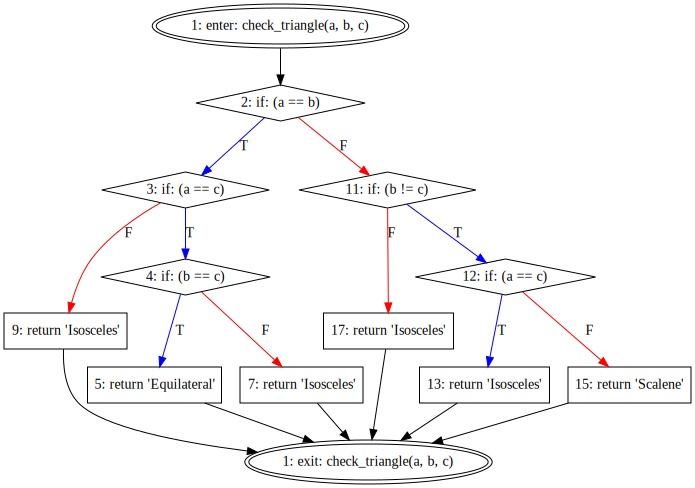

In [6]:
Source(to_graph(gen_cfg(inspect.getsource(check_triangle))))

The possible execution paths traced by the program can be represented as follows, with the numbers indicating the specific line numbers executed.

In [7]:
paths = {
    '<path 1>': ([1, 2, 3, 4, 5], 'Equilateral'),
    '<path 2>': ([1, 2, 3, 4, 7], 'Isosceles'),
    '<path 3>': ([1, 2, 3, 9], 'Isosceles'),
    '<path 4>': ([1, 2, 11, 12, 13], 'Isosceles'),
    '<path 5>': ([1, 2, 11, 12, 15], 'Scalene'),
    '<path 6>': ([1, 2, 11, 17], 'Isosceles'),
}

Consider the `<path 1>`. To trace this path, we need to execute the following statements in order.

```python
1: check_triangle(a, b, c)
2: if (a == b) -> True
3: if (a == c) -> True
4: if (b == c) -> True
5: return 'Equilateral'
```

That is, any execution that traces this path has to start with values for `a`, `b`, and `c` that obeys the constraints in line numbers `2: (a == b)` evaluates to `True`, `3: (a == c)` evaluates to `True`, and `4: (b == c)` evaluates to `True`. Can we generate inputs such that these constraints are satisfied?

One of the ways to solve such constraints is to use an [SMT solver](https://en.wikipedia.org/wiki/Satisfiability_modulo_theories) such as [z3](http://theory.stanford.edu/~nikolaj/programmingz3.html). Here is how one would go about solving the set of equations using *z3*.

In [8]:
import z3

First, we declare a set of variables as symbolic integers using *z3*.

*A symbolic variable can be thought of as a sort of placeholder for the real variable, sort of like the `x` in solving for `x` in Algebra. We identify what conditions the variable is supposed to obey, and finally produce a value that obeys all*

In [9]:
a, b, c = z3.Int('a'), z3.Int('b'), z3.Int('c')

We can now ask *z3* to solve the set of equations for us as follows.

In [10]:
z3.solve(a == b, a == c, b == c)

[a = 0, b = 0, c = 0]


Here we find the first problem in our program. Our program seems to not check whether the sides are greater than zero. Assume for now that we do not have that restriction. Does our program correctly follow the path described?

We can use the `Coverage` from the [chapter on coverage](Coverage.ipynb) as a tracer to visualize that information as below.

In [11]:
from Coverage import Coverage

We modify the tracer to report *all* traced events.

In [12]:
class Tracer(Coverage):
    def traceit(self, frame, event, args):
        if event != 'return':
            f = inspect.getframeinfo(frame)
            self._trace.append((f.function, f.lineno))
        return self.traceit

First, we recover the trace.

In [13]:
with Tracer() as cov:
    assert check_triangle(0, 0, 0) == 'Equilateral'
cov._trace

[('check_triangle', 1),
 ('check_triangle', 2),
 ('check_triangle', 3),
 ('check_triangle', 4),
 ('check_triangle', 5),
 ('__exit__', 24),
 ('__exit__', 25)]

To plot the path taken, we need to extract edges from the coverage.
We define a procedure `cov_to_arcs()` to translate our coverage to a list of edges.

In [14]:
def cov_to_arcs(cov):
    t = [i for f, i in cov._trace]
    return list(zip(t, t[1:]))

In [15]:
cov_to_arcs(cov)

[(1, 2), (2, 3), (3, 4), (4, 5), (5, 24), (24, 25)]

We can now determine the path taken.

### The CFG with path taken

In [16]:
check_triangle_src = inspect.getsource(check_triangle).strip()

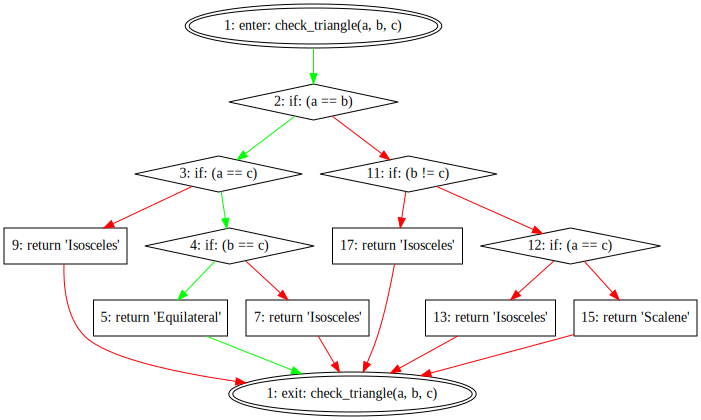

In [17]:
Source(to_graph(gen_cfg(check_triangle_src), arcs=cov_to_arcs(cov)))

As you can see, the path taken is `<path 1>`.

Similarly, for solving `<path 2>` we need to simply invert the condition at <line 2>:

In [18]:
a, b, c = z3.Ints('a b c')

In [19]:
z3.solve(a == b, a == c, z3.Not(b == c))

no solution


The symbolic execution suggests that there is no solution. A moment's reflection will convince us that it is indeed true. Let us proceed with the other paths. The `<path 3>` can be obtained by inverting the condition at `<line 4>`.

In [20]:
a, b, c = z3.Ints('a b c')

In [21]:
z3.solve(a == b, z3.Not(a == c))

[c = 0, b = 1, a = 1]


In [22]:
with Tracer() as cov:
    assert check_triangle(1, 1, 0) == 'Isosceles'
[i for fn, i in cov._trace if fn == 'check_triangle']

[1, 2, 3, 9]

How about path <4>?

In [23]:
a, b, c = z3.Ints('a b c')

In [24]:
z3.solve(z3.Not(a == b), b != c, a == c)

[b = 0, c = -1, a = -1]


As we mentioned earlier, our program does not account for sides with zero or negative length. We can modify our program to check for zero and negative input. However, do we always have to make sure that every function has to account for all possible inputs? It is possible that the `check_triangle` is not directly exposed to the user, and it is called from another function that already guarantees that the inputs would be positive.

We can easily add such a precondition here.

In [25]:
pre_condition = z3.And(a > 0, b > 0, c > 0)

In [26]:
z3.solve(pre_condition, z3.Not(a == b), b != c, a == c)

[c = 1, b = 2, a = 1]


In [27]:
with Tracer() as cov:
    assert check_triangle(1, 2, 1) == 'Isosceles'
[i for fn, i in cov._trace if fn == 'check_triangle']

[1, 2, 11, 12, 13]

In [28]:
paths['<path 4>']

([1, 2, 11, 12, 13], 'Isosceles')

Continuing to path <5>:

In [29]:
a, b, c = z3.Ints('a b c')

In [30]:
z3.solve(pre_condition, z3.Not(a == b), b != c, z3.Not(a == c))

[b = 1, a = 3, c = 2]


And indeed it is a *Scalene* triangle.

In [31]:
with Tracer() as cov:
    assert check_triangle(3, 1, 2) == 'Scalene'
[i for fn, i in cov._trace if fn == 'check_triangle']

[1, 2, 11, 12, 15]

In [32]:
paths['<path 5>']

([1, 2, 11, 12, 15], 'Scalene')

Finally, for `<path 6>` the procedure is similar.

In [33]:
z3.solve(pre_condition, z3.Not(a == b), z3.Not(b != c))

[c = 1, a = 2, b = 1]


In [34]:
with Tracer() as cov:
    assert check_triangle(2, 1, 1) == 'Isosceles'
[i for fn, i in cov._trace if fn == 'check_triangle']

[1, 2, 11, 17]

In [35]:
paths['<path 6>']

([1, 2, 11, 17], 'Isosceles')

What if we wanted another solution? We can simply ask the solver to solve again, and not give us the same values.

In [36]:
seen = [z3.And(a == 2, b == 1, c == 1)]

In [37]:
z3.solve(pre_condition, z3.Not(z3.Or(seen)), z3.Not(a == b), z3.Not(b != c))

[c = 2, a = 1, b = 2]


In [38]:
seen.append(z3.And(a == 1, b == 2, c == 2))

In [39]:
z3.solve(pre_condition, z3.Not(z3.Or(seen)), z3.Not(a == b), z3.Not(b != c))

[c = 1, a = 3, b = 1]


That is, using simple symbolic computation, we were able to easily see that (1) some of the paths are not reachable, and (2) some of the conditions were insufficient -- we needed preconditions. What about the total coverage obtained?

### Visualizing the coverage obtained

Visualizing the statement coverage can be accomplished as below.

In [40]:
class Tracer(Tracer):
    def show_coverage(self, fn):
        src = fn if isinstance(fn, str) else inspect.getsource(fn)
        covered = set([lineno for method, lineno in self._trace])
        for i, s in enumerate(src.split('\n')):
            print('%s %2d: %s' % ('#' if i + 1 in covered else ' ', i + 1, s))

We run all the inputs obtained under the coverage tracer.

In [41]:
with Tracer() as cov:
    assert check_triangle(0, 0, 0) == 'Equilateral'
    assert check_triangle(1, 1, 0) == 'Isosceles'
    assert check_triangle(1, 2, 1) == 'Isosceles'
    assert check_triangle(3, 1, 2) == 'Scalene'
    assert check_triangle(2, 1, 1) == 'Isosceles'

In [42]:
cov.show_coverage(check_triangle)

#  1: def check_triangle(a, b, c):
#  2:     if a == b:
#  3:         if a == c:
#  4:             if b == c:
#  5:                 return "Equilateral"
   6:             else:
   7:                 return "Isosceles"
   8:         else:
#  9:             return "Isosceles"
  10:     else:
# 11:         if b != c:
# 12:             if a == c:
# 13:                 return "Isosceles"
  14:             else:
# 15:                 return "Scalene"
  16:         else:
# 17:             return "Isosceles"
  18: 


The coverage is as expected. The generated values does seem to cover all code that can be covered.

### Function summaries

Now, consider this equation for determining absolute value.

In [43]:
def abs_value(x):
    if x < 0:
        v = -x
    else:
        v = x
    return v

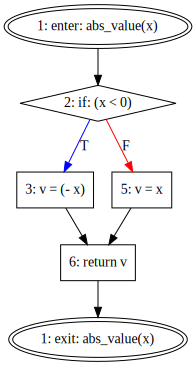

In [44]:
Source(to_graph(gen_cfg(inspect.getsource(abs_value))))

What can we say about the value of `v` at `line: 5`? Let us trace and see. First, we have variable `x` at `line: 1`.

In [45]:
x = z3.Int('x')

At `line: 2`, we face a bifurcation in the possible paths. Hence, we produce two paths with corresponding constraints.

In [46]:
l2_F = x < 0
l2_T = z3.Not(x < 0)

For `line: 3`, we only need to consider the `If` path. However, we have an assignment. So we use a new variable here.

In [47]:
v_0 = z3.Int('v_0')
l3 = z3.And(l2_F, v_0 == -x)

Similarly, for `line: 5`, we have an assignment. (Can we reuse the variable `v_0` from before?)

In [48]:
v_1 = z3.Int('v_1')
l5 = z3.And(l2_T, v_1 == x)

When we come to `line: 6`, we see that we have *two* input streams. We have a choice. We can either keep each path separate as we did previously.

In [49]:
v = z3.Int('v')
for s in [z3.And(l3, v == v_0), z3.And(l5, v == v_1)]:
    z3.solve(x != 0, s)

[x = -1, v = 1, v_0 = 1]
[x = 1, v = 1, v_1 = 1]


Or, we can combine them together and produce a single predicate at `line: 6`.

In [50]:
v = z3.Int('v')
l6 = z3.Or(z3.And(l3, v == v_0), z3.And(l5, v == v_1))
z3.solve(l6)

[v_0 = -1, v = 0, v_1 = 0, x = 0]


**Note.** Mering two incoming streams of execution can be non-trivial, especially when the execution paths are traversed multiple times (E.g. loops and recursion). For those interested, lookup [inferring loop invariants](https://www.st.cs.uni-saarland.de/publications/details/galeotti-hvc-2014/).

We can get this to produce any number of solutions for `abs()` as below.

In [51]:
s = z3.Solver()
s.add(l6)
for i in range(5):
    if s.check() == z3.sat:
        m = s.model()
        x_val = m[x]
        print(m)
    else:
        print('no solution')
        break
    s.add(z3.Not(x == x_val))
s

[v_0 = -1, v = 0, v_1 = 0, x = 0]
[v = 1, v_1 = 1, x = 1]
[v = 2, v_1 = 2, x = 2]
[v = 3, v_1 = 3, x = 3]
[v = 4, v_1 = 4, x = 4]


[Or(And(And(x < 0, v_0 == -x), v == v_0),
    And(And(Not(x < 0), v_1 == x), v == v_1)),
 Not(0 == x),
 Not(1 == x),
 Not(2 == x),
 Not(3 == x),
 Not(4 == x)]

The solver is not particularly random. So we need to help it a bit to produce values on the negative range.

In [52]:
s.add(x < 0)
for i in range(5):
    if s.check() == z3.sat:
        m = s.model()
        x_val = m[x]
        print(m)
    else:
        print('no solution')
        break
    s.add(z3.Not(x == x_val))

s

[v_0 = 1, v = 1, x = -1]
[v_0 = 2, v = 2, x = -2]
[v_0 = 3, v = 3, x = -3]
[v_0 = 4, v = 4, x = -4]
[v_0 = 5, v = 5, x = -5]


[Or(And(And(x < 0, v_0 == -x), v == v_0),
    And(And(Not(x < 0), v_1 == x), v == v_1)),
 Not(0 == x),
 Not(1 == x),
 Not(2 == x),
 Not(3 == x),
 Not(4 == x),
 x < 0,
 Not(-1 == x),
 Not(-2 == x),
 Not(-3 == x),
 Not(-4 == x),
 Not(-5 == x)]

Note that the single expression produced at `line: 6` is essentially a summary for `abs_value()`. 

In [53]:
abs_value_summary = l6
abs_value_summary

Or(And(And(x < 0, v_0 == -x), v == v_0),
   And(And(Not(x < 0), v_1 == x), v == v_1))

The *z3* solver can be used to simplify the predicates where possible.

In [54]:
z3.simplify(l6)

Or(And(Not(0 <= x), v_0 == -1*x, v == v_0),
   And(0 <= x, v_1 == x, v == v_1))

One can use this summary rather than trace into `abs_value()` when `abs_value()` is used elsewhere. For that, we need to convert this summary into a form that is usable in other places.

In [55]:
import ast
import astunparse

#### prefix_vars
The method `prefix_vars()` modifies the variables in an expression such that the variables are prefixed with a given value.

In [56]:
def prefix_vars(astnode, prefix):
    if isinstance(astnode, ast.BoolOp):
        return ast.BoolOp(astnode.op,
                          [prefix_vars(i, prefix) for i in astnode.values], [])
    elif isinstance(astnode, ast.BinOp):
        return ast.BinOp(
            prefix_vars(astnode.left, prefix), astnode.op,
            prefix_vars(astnode.right, prefix))
    elif isinstance(astnode, ast.UnaryOp):
        return ast.UnaryOp(astnode.op, prefix_vars(astnode.operand, prefix))
    elif isinstance(astnode, ast.Call):
        return ast.Call(prefix_vars(astnode.func, prefix),
                        [prefix_vars(i, prefix) for i in astnode.args],
                        astnode.keywords)
    elif isinstance(astnode, ast.Compare):
        return ast.Compare(
            prefix_vars(astnode.left, prefix), astnode.ops,
            [prefix_vars(i, prefix) for i in astnode.comparators])
    elif isinstance(astnode, ast.Name):
        if astnode.id in {'And', 'Or', 'Not'}:
            return ast.Name('z3.%s' % (astnode.id), astnode.ctx)
        else:
            return ast.Name('%s_%s' % (prefix, astnode.id), astnode.ctx)
    elif isinstance(astnode, ast.Return):
        return ast.Return(prefix_vars(astnode.value, env))
    else:
        return astnode

The function `to_src()` allows us to *unparse* an expression.

In [57]:
def to_src(astnode):
    return astunparse.unparse(astnode).strip()

In [58]:
def get_expression(src):
    return ast.parse(src).body[0].value

Now, we can combine both pieces to produce a prefixed expression as below.

In [59]:
abs_value_summary_ast = get_expression(str(abs_value_summary))
to_src(prefix_vars(abs_value_summary_ast, 'x1'))

'z3.Or(z3.And(z3.And((x1_x < 0), (x1_v_0 == (- x1_x))), (x1_v == x1_v_0)), z3.And(z3.And(z3.Not((x1_x < 0)), (x1_v_1 == x1_x)), (x1_v == x1_v_1)))'

#### names

We need the names of variables used in an expression to declare the to declare them. The method `names()` extracts variables used.

In [60]:
def names(astnode):
    lst = []
    if isinstance(astnode, ast.BoolOp):
        for i in astnode.values:
            lst.extend(names(i))
    elif isinstance(astnode, ast.BinOp):
        lst.extend(names(astnode.left))
        lst.extend(names(astnode.right))
    elif isinstance(astnode, ast.UnaryOp):
        lst.extend(names(astnode.operand))
    elif isinstance(astnode, ast.Call):
        for i in astnode.args:
            lst.extend(names(i))
    elif isinstance(astnode, ast.Compare):
        lst.extend(names(astnode.left))
        for i in astnode.comparators:
            lst.extend(names(i))
    elif isinstance(astnode, ast.Name):
        lst.append(astnode.id)
    elif isinstance(astnode, ast.Expr):
        lst.extend(names(astnode.value))
    elif isinstance(astnode, (ast.Num, ast.Str, ast.Tuple, ast.NameConstant)):
        pass
    elif isinstance(astnode, ast.Assign):
        for t in astnode.targets:
            lst.extend(names(t))
        lst.extend(names(astnode.value))
    elif isinstance(astnode, ast.Module):
        for b in astnode.body:
            lst.extend(names(b))
    else:
        raise Exception(str(astnode))
    return list(set(lst))

With this, we can now extract the variables used in an expression.

In [61]:
v = ast.parse('fn(x+z,y>(a+b)) == c')
names(v)

['x', 'a', 'b', 'z', 'y', 'c']

In [62]:
abs_value_vars = names(ast.parse(str(abs_value_summary)))
abs_value_vars

['v_0', 'x', 'v_1', 'v']

Registering functions for later use.

In [63]:
function_summaries = {}
function_summaries['abs_value'] = {
    'predicate': str(abs_value_summary),
    'vars': abs_value_vars}

In [64]:
def define_vars(fn_vars, sym_fn='z3.Int'):
    sym_var_dec = ', '.join(fn_vars)
    sym_var_def = ', '.join(["%s('%s')" % (sym_fn, i) for i in fn_vars])
    return "%s = %s" % (sym_var_dec, sym_var_def)

In [65]:
def gen_fn_summary(prefix, fn, sym_fn='z3.Int'):
    fn_name = fn.__name__
    summary = function_summaries[fn_name]
    summary_ast = ast.parse(summary['predicate']).body[0].value
    fn_vars = ["%s_%s" % (prefix, s) for s in summary['vars']]
    declarations = define_vars(fn_vars, sym_fn)
    return declarations, to_src(prefix_vars(summary_ast, prefix))

In [66]:
gen_fn_summary('a', abs_value)

("a_v_0, a_x, a_v_1, a_v = z3.Int('a_v_0'), z3.Int('a_x'), z3.Int('a_v_1'), z3.Int('a_v')",
 'z3.Or(z3.And(z3.And((a_x < 0), (a_v_0 == (- a_x))), (a_v == a_v_0)), z3.And(z3.And(z3.Not((a_x < 0)), (a_v_1 == a_x)), (a_v == a_v_1)))')

In [67]:
gen_fn_summary('b', abs_value)

("b_v_0, b_x, b_v_1, b_v = z3.Int('b_v_0'), z3.Int('b_x'), z3.Int('b_v_1'), z3.Int('b_v')",
 'z3.Or(z3.And(z3.And((b_x < 0), (b_v_0 == (- b_x))), (b_v == b_v_0)), z3.And(z3.And(z3.Not((b_x < 0)), (b_v_1 == b_x)), (b_v == b_v_1)))')

How do we use our function summaries? Here is a function `abs_max()` that uses `abs_value()`.

In [68]:
def abs_max(a, b):
    a1 = abs_value(a)
    b1 = abs_value(b)
    if a1 > b1:
        c = a1
    else:
        c = b1
    return c

To trace this function symbolically, we first define the two variables `a` and `b`.

In [69]:
a = z3.Int('a')
b = z3.Int('b')

The `line: 2` contains definition for `a1`, which we define as a symbolic variable.

In [70]:
a1 = z3.Int('a1')

We also need to call `abs_value()`, which is accomplished as follows. Since this is the first call to `abs_value()`, we use `abs1` as the prefix.

In [71]:
d, v = gen_fn_summary('abs1', abs_value)
v

'z3.Or(z3.And(z3.And((abs1_x < 0), (abs1_v_0 == (- abs1_x))), (abs1_v == abs1_v_0)), z3.And(z3.And(z3.Not((abs1_x < 0)), (abs1_v_1 == abs1_x)), (abs1_v == abs1_v_1)))'

We also need to equate the resulting value (`<prefix>_v`) to the symbolic variable `a1` we defined earlier.

In [72]:
l2_src = "l2 = z3.And(a == abs1_x, a1 == abs1_v, %s)" % v
l2_src

'l2 = z3.And(a == abs1_x, a1 == abs1_v, z3.Or(z3.And(z3.And((abs1_x < 0), (abs1_v_0 == (- abs1_x))), (abs1_v == abs1_v_0)), z3.And(z3.And(z3.Not((abs1_x < 0)), (abs1_v_1 == abs1_x)), (abs1_v == abs1_v_1))))'

Applying both declaration and the assignment.

In [73]:
exec(d)
exec(l2_src)

In [74]:
l2

And(a == abs1_x,
    a1 == abs1_v,
    Or(And(And(abs1_x < 0, abs1_v_0 == -abs1_x),
           abs1_v == abs1_v_0),
       And(And(Not(abs1_x < 0), abs1_v_1 == abs1_x),
           abs1_v == abs1_v_1)))

We need to do the same for `line: 3`, but with `abs2` as the prefix.

In [75]:
b1 = z3.Int('b1')
d, v = gen_fn_summary('abs2', abs_value)
l3_src = "l3_ = z3.And(b == abs2_x, b1 == abs2_v, %s)" % v
exec(d)
exec(l3_src)

In [76]:
l3_

And(b == abs2_x,
    b1 == abs2_v,
    Or(And(And(abs2_x < 0, abs2_v_0 == -abs2_x),
           abs2_v == abs2_v_0),
       And(And(Not(abs2_x < 0), abs2_v_1 == abs2_x),
           abs2_v == abs2_v_1)))

To get the true set of predicates at `line: 3`, we need to add the predicates from `line: 2`.

In [77]:
l3 = z3.And(l2, l3_)

In [78]:
l3

And(And(a == abs1_x,
        a1 == abs1_v,
        Or(And(And(abs1_x < 0, abs1_v_0 == -abs1_x),
               abs1_v == abs1_v_0),
           And(And(Not(abs1_x < 0), abs1_v_1 == abs1_x),
               abs1_v == abs1_v_1))),
    And(b == abs2_x,
        b1 == abs2_v,
        Or(And(And(abs2_x < 0, abs2_v_0 == -abs2_x),
               abs2_v == abs2_v_0),
           And(And(Not(abs2_x < 0), abs2_v_1 == abs2_x),
               abs2_v == abs2_v_1))))

This equation can be simplified a bit using z3.

In [79]:
z3.simplify(l3)

And(a == abs1_x,
    a1 == abs1_v,
    Or(And(Not(0 <= abs1_x),
           abs1_v_0 == -1*abs1_x,
           abs1_v == abs1_v_0),
       And(0 <= abs1_x,
           abs1_v_1 == abs1_x,
           abs1_v == abs1_v_1)),
    b == abs2_x,
    b1 == abs2_v,
    Or(And(Not(0 <= abs2_x),
           abs2_v_0 == -1*abs2_x,
           abs2_v == abs2_v_0),
       And(0 <= abs2_x,
           abs2_v_1 == abs2_x,
           abs2_v == abs2_v_1)))

Coming to `line: 4`, we have a condition.

In [80]:
l4_cond = a1 > b1
l4 = z3.And(l3, l4_cond)

For `line: 5`, we define the symbolic variable `c_0` assuming we took the *IF* branch.

In [81]:
c_0 = z3.Int('c_0')
l5 = z3.And(l4, c_0 == a1)

For `line: 6`, the *ELSE* branch was taken. So we invert that condition.

In [82]:
l6 = z3.And(l3, z3.Not(l4_cond))

For `line: 7`, we define `c_1`.

In [83]:
c_1 = z3.Int('c_1')
l7 = z3.And(l6, c_1 == b1)

In [84]:
s1 = z3.Solver()
s1.add(l5)
s1.check()

sat

In [85]:
m1 = s1.model()
sorted([(d, m1[d]) for d in m1.decls() if not d.name(
).startswith('abs')], key=lambda x: x[0].name())

[(a, 1), (a1, 1), (b, 0), (b1, 0), (c_0, 1)]

In [86]:
s2 = z3.Solver()
s2.add(l7)
s2.check()

sat

In [87]:
m2 = s2.model()
sorted([(d, m2[d]) for d in m2.decls() if not d.name(
).startswith('abs')], key=lambda x: x[0].name())

[(a, 1), (a1, 1), (b, 1), (b1, 1), (c_1, 1)]

What we really want to do is to automate this process, because doing this by hand is tedious and error prone. Essentially, we want the ability to extract *all paths* in the program, and symbolically execute each path, which will generate the inputs required to cover all reachable portions of the program.

## Symbolic Execution

We define a simple *symbolic fuzzer* that can generate input values *symbolically* with the following assumptions:

* There are no loops in the program
* The function is self contained.
* No recursion.
* No reassignments for variables.

The key idea is as follows: We traverse through the control flow graph from the entry point, and generate all possible paths to a given depth. Then we collect constraints that we encountered along the path, and generate inputs that will traverse the program up to that point.

We build our fuzzer based on the class `Fuzzer`.

In [88]:
from Fuzzer import Fuzzer

### SimpleSymbolicFuzzer

We start by extracting the control flow graph of the function passed. We also provide a hook for child classes to do their processing.

In [89]:
class SimpleSymbolicFuzzer(Fuzzer):
    def __init__(self, fn, **kwargs):
        self.fn = fn
        self.fn_src = inspect.getsource(fn)
        self.fn_args = list(inspect.signature(fn).parameters)
        self.py_cfg = PyCFG()
        self.py_cfg.gen_cfg(self.fn_src)
        self.fnenter, self.fnexit = self.py_cfg.functions[fn.__name__]
        self.paths = None
        self.last_path = None
        self.removed_solutions = []
        self.z3 = z3.Solver()
        self.options(kwargs)
        self.process()

    def process(self):
        pass

We need a few variables to control how much we are willing to traverse.

`MAX_DEPTH` is the depth to which one should attempt to trace the execution.

In [90]:
MAX_DEPTH = 100

`MAX_TRIES` is the maximum number of attempts we will try to produce a value before giving up.

In [91]:
MAX_TRIES = 100

`MAX_ITER` is the number of iterations we will attempt.

In [92]:
MAX_ITER = 100

The `options()` method sets these parameters in the fuzzing class.

In [93]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def options(self, kwargs):
        self.max_depth = kwargs.get('max_depth', MAX_DEPTH)
        self.max_tries = kwargs.get('max_tries', MAX_TRIES)
        self.max_iter = kwargs.get('max_iter', MAX_ITER)
        self.symbolic_fn = kwargs.get('symbolic_fn', 'z3.Int')
        self._options = kwargs

The initialization generates a control flow graph and hooks it to `fnenter` and `fnexit`.

In [94]:
symfz_ct = SimpleSymbolicFuzzer(check_triangle)

In [95]:
symfz_ct.fnenter, symfz_ct.fnexit

(id:9 line[1] parents: [] : enter: check_triangle(a, b, c),
 id:10 line[1] parents: [14, 15, 16, 19, 20, 21] : exit: check_triangle(a, b, c))

#### get_all_paths
We can use the procedure `get_all_paths()` starting from `fnenter` to recursively retrieve all paths in the function.

In the CFG, in the case of if-then-else branches, the first node is the `If` branch, while the second node is the `Else` branch. Hence, we keep track of the order of definition in `idx`.

In [96]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def get_all_paths(self, fenter, depth=0):
        if depth > self.max_depth:
            raise Exception('Maximum depth exceeded')
        if not fenter.children:
            return [[(0, fenter)]]

        fnpaths = []
        for idx, child in enumerate(fenter.children):
            child_paths = self.get_all_paths(child, depth + 1)
            for path in child_paths:
                fnpaths.append([(idx, fenter)] + path)
        return fnpaths

This can be used as follows.

In [97]:
symfz_ct = SimpleSymbolicFuzzer(check_triangle)
paths = symfz_ct.get_all_paths(symfz_ct.fnenter)
print(len(paths))
paths[1]

6


[(0, id:24 line[1] parents: [] : enter: check_triangle(a, b, c)),
 (0, id:26 line[2] parents: [24] : _if: (a == b)),
 (0, id:27 line[3] parents: [26] : _if: (a == c)),
 (1, id:28 line[4] parents: [27] : _if: (b == c)),
 (0, id:30 line[7] parents: [28] : return 'Isosceles'),
 (0,
  id:25 line[1] parents: [29, 30, 31, 34, 35, 36] : exit: check_triangle(a, b, c))]

We hook `get_all_paths()` to initialization as below.

In [98]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def process(self):
        self.paths = self.get_all_paths(self.fnenter)
        self.last_path = len(self.paths)

#### extract_constraints

For any given path, we define a function `extract_constraints()` to extract the constraints in `z3` format. Given that the order of the child shows which branch was taken, we need to shift

In [99]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def extract_constraints(self, path):
        predicates = []
        for (idx, elt) in path:
            if isinstance(elt.ast_node, ast.AnnAssign):
                if elt.ast_node.target.id in {'_if', '_while'}:
                    s = to_src(elt.ast_node.annotation)
                    predicates.append(("%s" if idx == 0 else "z3.Not%s") % s)
            elif isinstance(elt.ast_node, ast.Assign):
                predicates.append(to_src(elt.ast_node))
            else:
                pass
        return predicates

In [100]:
symfz_ct = SimpleSymbolicFuzzer(check_triangle)
paths = symfz_ct.get_all_paths(symfz_ct.fnenter)
constraints = symfz_ct.extract_constraints(paths[1])
constraints

['(a == b)', '(a == c)', 'z3.Not(b == c)']

The method `used_vars()` extracts the symbolic variables to be defined from an expression.

In [101]:
def used_vars(predicates):
    return list(set([n for p in predicates for n in names(get_expression(p))]))

In [102]:
used_vars(constraints)

['a', 'b', 'c']

In [103]:
symfz_ct.extract_constraints(paths[0])

['(a == b)', '(a == c)', '(b == c)']

#### Fuzzing with our simple fuzzer

To actually generate solutions, we define `fuzz()`. For that, we need to first extract all paths. Then choose a particular path, and extract the constraints in that path, which is then solved using *z3*.

In [104]:
from contextlib import contextmanager

First we create a checkpoint for our current solver so that we can check a predicate, and rollback if necessary.

In [105]:
@contextmanager
def checkpoint(z3solver):
    z3solver.push()
    yield z3solver
    z3solver.pop()

The `use_path()` function extracts constraints for a single function, applies it to our current solver (under a checkpoint), and returns the results if some solutions can be found.

If solutions were found, we also make sure that we never reuse those solutions.

In [106]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def solve_path_constraint(self, path):
        # re-initializing does not seem problematic.
        # a = z3.Int('a').get_id() remains the same.
        constraints = self.extract_constraints(path)
        exec(define_vars(used_vars(constraints), self.symbolic_fn))

        solutions = {}
        with checkpoint(self.z3):
            st = 'self.z3.add(%s)' % ', '.join(constraints)
            eval(st)
            if self.z3.check() != z3.sat:
                return {}
            m = self.z3.model()
            solutions = {d.name(): m[d] for d in m.decls()}
            my_args = {k: solutions.get(k, None) for k in self.fn_args}
        predicate = 'z3.And(%s)' % ','.join(
            ["%s == %s" % (k, v) for k, v in my_args.items()])
        eval('self.z3.add(z3.Not(%s))' % predicate)
        return my_args

We define `get_path()` that retrieves the current path and updates the path used.

In [107]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def get_next_path(self):
        self.last_path -= 1
        if self.last_path == -1:
            self.last_path = len(self.paths) - 1
        return self.paths[self.last_path]

The `fuzz()` method simply solves each path in order.

In [108]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def fuzz(self):
        for i in range(self.max_tries):
            res = self.solve_path_constraint(self.get_next_path())
            if res:
                return res
        return {}

The fuzzer can be used as follows.

In [109]:
a, b, c = None, None, None
symfz_ct = SimpleSymbolicFuzzer(check_triangle)
for i in range(1, 10):
    r = symfz_ct.fuzz()
    v = check_triangle(r['a'].as_long(), r['b'].as_long(), r['c'].as_long())
    print(r, "result:", v)

{'a': 0, 'b': 1, 'c': 1} result: Isosceles
{'a': 1, 'b': 2, 'c': 3} result: Scalene
{'a': 2, 'b': 0, 'c': 2} result: Isosceles
{'a': 0, 'b': 0, 'c': 4} result: Isosceles
{'a': 1, 'b': 1, 'c': 1} result: Equilateral
{'a': 2, 'b': 3, 'c': 3} result: Isosceles
{'a': 4, 'b': 5, 'c': 6} result: Scalene
{'a': 4, 'b': 2, 'c': 4} result: Isosceles
{'a': 2, 'b': 2, 'c': 5} result: Isosceles


#### Problems with the Simple Fuzzer

As we mentioned earlier, the `SimpleSymbolicFuzzer` cannot yet deal with variable reassignments. Further, it also fails to account for any loops. For example, consider the following program.

In [110]:
def gcd(a, b):
    if a < b:
        c = a
        a = b
        b = c

    while b != 0:
        c = a
        a = b
        b = c % b
    return a

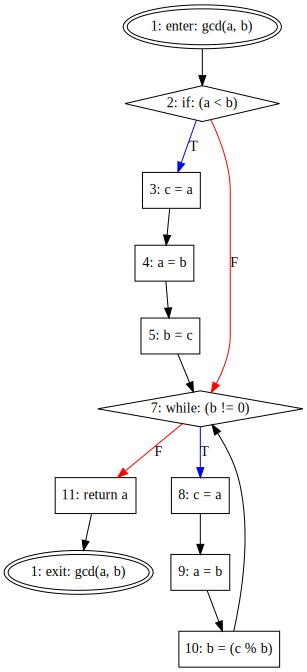

In [111]:
Source(to_graph(gen_cfg(inspect.getsource(gcd))))

In [112]:
from ExpectError import ExpectError

In [113]:
with ExpectError():
    symfz_gcd = SimpleSymbolicFuzzer(gcd)
    for i in range(1, 100):
        r = symfz_gcd.fuzz()
        v = gcd(r['a'].as_long(), r['b'].as_long())
        print(r, v)

Traceback (most recent call last):
  File "<ipython-input-113-e63c685aac70>", line 2, in <module>
    symfz_gcd = SimpleSymbolicFuzzer(gcd)
  File "<ipython-input-89-d395d767fa77>", line 14, in __init__
    self.process()
  File "<ipython-input-98-6bc97a9e8eb0>", line 3, in process
    self.paths = self.get_all_paths(self.fnenter)
  File "<ipython-input-96-11757c1bd8b3>", line 10, in get_all_paths
    child_paths = self.get_all_paths(child, depth + 1)
  File "<ipython-input-96-11757c1bd8b3>", line 10, in get_all_paths
    child_paths = self.get_all_paths(child, depth + 1)
  File "<ipython-input-96-11757c1bd8b3>", line 10, in get_all_paths
    child_paths = self.get_all_paths(child, depth + 1)
  [Previous line repeated 97 more times]
  File "<ipython-input-96-11757c1bd8b3>", line 4, in get_all_paths
    raise Exception('Maximum depth exceeded')
Exception: Maximum depth exceeded (expected)


### Advanced Symbolic Fuzzer

We next define `AdvancedSymbolicFuzzer` that can deal with reassignments and *unrolling of loops*.

In [114]:
class AdvancedSymbolicFuzzer(SimpleSymbolicFuzzer):
    def options(self, kwargs):
        super().options(kwargs)

Once we allow reassignments and loop unrolling, we have to deal with what to call the new variables generated. This is what we will tackle next.

#### rename_variables

We want to rename all variables present in an expression such that the variables are annotated with their usage count. This makes it possible to determine variable reassignments.  To do that, we define the `rename_variables()` function that, when given an `env` that contains the current usage index of different variables, renames the variables in the passed in AST node with the annotations.

That is, if the expression is `env[v] == 1`, `v` is renamed to `_v_1`

In [115]:
def rename_variables(astnode, env):
    if isinstance(astnode, ast.BoolOp):
        fn = 'z3.And' if isinstance(astnode.op, ast.And) else 'z3.Or'
        return ast.Call(
            ast.Name(fn, None),
            [rename_variables(i, env) for i in astnode.values], [])
    elif isinstance(astnode, ast.BinOp):
        return ast.BinOp(
            rename_variables(astnode.left, env), astnode.op,
            rename_variables(astnode.right, env))
    elif isinstance(astnode, ast.UnaryOp):
        if isinstance(astnode.op, ast.Not):
            return ast.Call(
                ast.Name('z3.Not', None),
                [rename_variables(astnode.operand, env)], [])
        else:
            return ast.UnaryOp(astnode.op,
                               rename_variables(astnode.operand, env))
    elif isinstance(astnode, ast.Call):
        return ast.Call(astnode.func,
                        [rename_variables(i, env) for i in astnode.args],
                        astnode.keywords)
    elif isinstance(astnode, ast.Compare):
        return ast.Compare(
            rename_variables(astnode.left, env), astnode.ops,
            [rename_variables(i, env) for i in astnode.comparators])
    elif isinstance(astnode, ast.Name):
        if astnode.id not in env:
            env[astnode.id] = 0
        num = env[astnode.id]
        return ast.Name('_%s_%d' % (astnode.id, num), astnode.ctx)
    elif isinstance(astnode, ast.Return):
        return ast.Return(rename_variables(astnode.value, env))
    else:
        return astnode

To verify that it works ans intended, we start with an environment.

In [116]:
env = {'x': 1}

In [117]:
ba = get_expression('x == 1 and y == 2')
type(ba)

_ast.BoolOp

In [118]:
assert to_src(rename_variables(ba, env)) == 'z3.And((_x_1 == 1), (_y_0 == 2))'

In [119]:
bo = get_expression('x == 1 or y == 2')
type(bo.op)

_ast.Or

In [120]:
assert to_src(rename_variables(bo, env)) == 'z3.Or((_x_1 == 1), (_y_0 == 2))'

In [121]:
b = get_expression('x + y')
type(b)

_ast.BinOp

In [122]:
assert to_src(rename_variables(b, env)) == '(_x_1 + _y_0)'

In [123]:
u = get_expression('-y')
type(u)

_ast.UnaryOp

In [124]:
assert to_src(rename_variables(u, env)) == '(- _y_0)'

In [125]:
un = get_expression('not y')
type(un.op)

_ast.Not

In [126]:
assert to_src(rename_variables(un, env)) == 'z3.Not(_y_0)'

In [127]:
c = get_expression('x == y')
type(c)

_ast.Compare

In [128]:
assert to_src(rename_variables(c, env)) == '(_x_1 == _y_0)'

In [129]:
f = get_expression('fn(x,y)')
type(f)

_ast.Call

In [130]:
assert to_src(rename_variables(f, env)) == 'fn(_x_1, _y_0)'

In [131]:
env

{'x': 1, 'y': 0}

Next, we want to process the CFG, and correctly transform the paths.

#### PNode

For keeping track of assignments in the CFG, We define a data structure `PNode` that stores the current CFG node.

In [132]:
class PNode:
    def __init__(self, idx, cfgnode, parent=None, order=0):
        self.idx, self.cfgnode, self.parent, self.order = idx, cfgnode, parent, order

    def __repr__(self):
        return "PNode:%d[%s order:%d]" % (self.idx, str(self.cfgnode),
                                          self.order)

Defining a new `PNode` is done as follows.

In [133]:
cfg = PyCFG()
cfg.gen_cfg(inspect.getsource(gcd))
fnenter, fnexit = cfg.functions['gcd']

In [134]:
PNode(0, fnenter)

PNode:0[id:27 line[1] parents: [] : enter: gcd(a, b) order:0]

##### copy
The `copy()` method generates a copy for the child's keep, indicating which path was taken (with `order` of the child).

In [135]:
class PNode(PNode):
    def copy(self, order):
        p = PNode(self.idx, self.cfgnode, self.parent, order)
        assert p.order == order
        return p

Using the copy operation.

In [136]:
PNode(0, fnenter).copy(1)

PNode:0[id:27 line[1] parents: [] : enter: gcd(a, b) order:1]

##### explore

A problem we had with our `SimpleSymbolicFuzzer` is that it explored a path to completion before attempting another. However, this is non-optimal. One may want to explore the graph in a more step-wise manner, expanding every possible execution one step at a time.

Hence, we define `explore()`  which explores the children of a node if any, one step at a time. If done exhaustively, this will generate all paths from a starting node until no more children are left. We made `PNode` to a container class so that this iteration can be driven from outside, and stopped if say a maximum iteration is complete, or certain paths need to be prioritized.

In [137]:
class PNode(PNode):
    def explore(self):
        return [
            PNode(self.idx + 1, n, self.copy(i))
            for (i, n) in enumerate(self.cfgnode.children)
        ]

We can use `explore()` as follows.

In [138]:
PNode(0, fnenter).explore()

[PNode:1[id:29 line[2] parents: [27] : _if: (a < b) order:0]]

In [139]:
PNode(0, fnenter).explore()[0].explore()

[PNode:2[id:30 line[3] parents: [29] : c = a order:0],
 PNode:2[id:33 line[7] parents: [32, 29, 36] : _while: (b != 0) order:0]]

##### get_path_to_root

The method `get_path_to_root()` recursively goes up through child->parent chain retrieving the complete chain to the topmost parent.

In [140]:
class PNode(PNode):
    def get_path_to_root(self):
        path = []
        n = self
        while n:
            path.append(n)
            n = n.parent
        return list(reversed(path))

In [141]:
p = PNode(0, fnenter)
[s.get_path_to_root() for s in p.explore()[0].explore()[0].explore()[0].explore()]

[[PNode:0[id:27 line[1] parents: [] : enter: gcd(a, b) order:0],
  PNode:1[id:29 line[2] parents: [27] : _if: (a < b) order:0],
  PNode:2[id:30 line[3] parents: [29] : c = a order:0],
  PNode:3[id:31 line[4] parents: [30] : a = b order:0],
  PNode:4[id:32 line[5] parents: [31] : b = c order:0]]]

The string representation of the node is in `z3` solvable form.

In [142]:
class PNode(PNode):
    def __str__(self):
        path = self.get_path_to_root()
        ssa_path = to_single_assignment_predicates(path)
        return ', '.join([to_src(p) for p in ssa_path])

However, before using it, we need to define the `rename_variables()`. But first, we define `names()`.

###### to_single_assignment_predicates

We need to rename used variables. Any variable `v = xxx` should be renamed to `_v_0` and any later assignment such as `v = v + 1` should be transformed to `_v_1 = _v_0 + 1` and later conditionals such as `v == x` should be transformed to `(_v_1 == _x_0)`. The method `to_single_assignment_predicates()` does this for a given path.

In [143]:
def to_single_assignment_predicates(path):
    env = {}
    new_path = []
    for i, node in enumerate(path):
        ast_node = node.cfgnode.ast_node
        new_node = None
        if isinstance(ast_node, ast.AnnAssign) and ast_node.target.id in {
                'exit'}:
            new_node = None
        elif isinstance(ast_node, ast.AnnAssign) and ast_node.target.id in {'enter'}:
            args = [
                ast.parse(
                    "%s == _%s_0" %
                    (a.id, a.id)).body[0].value for a in ast_node.annotation.args]
            new_node = ast.Call(ast.Name('z3.And', None), args, [])
        elif isinstance(ast_node, ast.AnnAssign) and ast_node.target.id in {'_if', '_while'}:
            new_node = rename_variables(ast_node.annotation, env)
            if node.order != 0:
                assert node.order == 1
                new_node = ast.Call(ast.Name('z3.Not', None), [new_node], [])
        elif isinstance(ast_node, ast.Assign):
            assigned = ast_node.targets[0].id
            val = [rename_variables(ast_node.value, env)]
            env[assigned] = 0 if assigned not in env else env[assigned] + 1
            target = ast.Name('_%s_%d' %
                              (ast_node.targets[0].id, env[assigned]), None)
            new_node = ast.Expr(ast.Compare(target, [ast.Eq()], val))
        elif isinstance(ast_node, (ast.Return, ast.Pass)):
            new_node = None
        else:
            s = "NI %s %s" % (type(ast_node), ast_node.target.id)
            raise Exception(s)
        new_path.append(new_node)
    return new_path

In [144]:
p = PNode(0, fnenter)
path = p.explore()[0].explore()[0].explore()[0].get_path_to_root()
spath = to_single_assignment_predicates(path)

In [145]:
[to_src(s) for s in spath]

['z3.And((a == _a_0), (b == _b_0))',
 '(_a_0 < _b_0)',
 '(_c_0 == _a_0)',
 '(_a_1 == _b_0)']

In [146]:
assert set(q for s in spath for q in names(s)) == {
    '_a_0', '_a_1', '_b_0', '_c_0', 'a', 'b'}

##### can_be_satisfied

One of the ways in which the *concolic* execution simplifies *symbolic* execution is in the treatment of loops. Rather than trying to determine an invariant for a loop, we simply *unroll* the loops a number of times until we hit the `MAX_DEPTH` limit. However, not all loops will need to be unrolled until `MAX_DEPTH` is reached. Some of them may exit before. Hence, it is necessary to check whether the given set of constraints can be satisfied before continuing to explore further. 

In [147]:
class AdvancedSymbolicFuzzer(AdvancedSymbolicFuzzer):
    def can_be_satisfied(self, p):
        s2 = self.extract_constraints(p.get_path_to_root())
        s = z3.Solver()
        exec(define_vars(used_vars(s2), self.symbolic_fn), globals(), locals())
        exec("s.add(z3.And(%s))" % ','.join(s2), globals(), locals())
        return s.check() == z3.sat

#### extract_constraints

The `extract_constraints()` generates the `z3` constraints from a path. The main work is done by `to_single_assignment_predicates()`. The `extract_constraints()` then converts the AST to source.

In [148]:
class AdvancedSymbolicFuzzer(AdvancedSymbolicFuzzer):
    def extract_constraints(self, path):
        return [to_src(p) for p in to_single_assignment_predicates(path) if p]

#### get_all_paths

Get all paths one can generate from function enter node (`fenter`) subject to max_depth limit.

In [149]:
class AdvancedSymbolicFuzzer(AdvancedSymbolicFuzzer):
    def get_all_paths(self, fenter):
        path_lst = [PNode(0, fenter)]
        completed = []
        for i in range(self.max_iter):
            new_paths = [PNode(0, fenter)]
            for path in path_lst:
                # explore each path once
                if path.cfgnode.children:
                    np = path.explore()
                    for p in np:
                        if path.idx > self.max_depth:
                            break
                        if self.can_be_satisfied(p):
                            new_paths.append(p)
                        else:
                            pass
                else:
                    completed.append(path)
            path_lst = new_paths
        return completed + path_lst

We can now obtain all paths using our advanced symbolic fuzzer as follows.

In [150]:
asymfz_gcd = AdvancedSymbolicFuzzer(
    gcd, max_iter=10, max_tries=10, max_depth=10)
paths = asymfz_gcd.get_all_paths(asymfz_gcd.fnenter)
print(len(paths))
paths[37].get_path_to_root()

38


[PNode:0[id:40 line[1] parents: [] : enter: gcd(a, b) order:0],
 PNode:1[id:42 line[2] parents: [40] : _if: (a < b) order:1],
 PNode:2[id:46 line[7] parents: [45, 42, 49] : _while: (b != 0) order:0],
 PNode:3[id:47 line[8] parents: [46] : c = a order:0],
 PNode:4[id:48 line[9] parents: [47] : a = b order:0],
 PNode:5[id:49 line[10] parents: [48] : b = (c % b) order:0],
 PNode:6[id:46 line[7] parents: [45, 42, 49] : _while: (b != 0) order:0],
 PNode:7[id:47 line[8] parents: [46] : c = a order:0],
 PNode:8[id:48 line[9] parents: [47] : a = b order:0],
 PNode:9[id:49 line[10] parents: [48] : b = (c % b) order:0],
 PNode:10[id:46 line[7] parents: [45, 42, 49] : _while: (b != 0) order:0]]

We can also list the predicates in each path.

In [151]:
for s in to_single_assignment_predicates(paths[37].get_path_to_root()):
    if s is not None:
        print(to_src(s))

z3.And((a == _a_0), (b == _b_0))
z3.Not((_a_0 < _b_0))
(_b_0 != 0)
(_c_0 == _a_0)
(_a_1 == _b_0)
(_b_1 == (_c_0 % _b_0))
(_b_1 != 0)
(_c_1 == _a_1)
(_a_2 == _b_1)
(_b_2 == (_c_1 % _b_1))
(_b_2 != 0)


In [152]:
constraints = asymfz_gcd.extract_constraints(paths[37].get_path_to_root())

In [153]:
constraints

['z3.And((a == _a_0), (b == _b_0))',
 'z3.Not((_a_0 < _b_0))',
 '(_b_0 != 0)',
 '(_c_0 == _a_0)',
 '(_a_1 == _b_0)',
 '(_b_1 == (_c_0 % _b_0))',
 '(_b_1 != 0)',
 '(_c_1 == _a_1)',
 '(_a_2 == _b_1)',
 '(_b_2 == (_c_1 % _b_1))',
 '(_b_2 != 0)']

In [154]:
used_vars(constraints)

['_b_0', 'a', 'b', '_a_0', '_b_1', '_a_2', '_c_0', '_c_1', '_a_1', '_b_2']

#### Fuzzing with our advanced fuzzer

In [155]:
class AdvancedSymbolicFuzzer(AdvancedSymbolicFuzzer):
    def get_next_path(self):
        self.last_path -= 1
        if self.last_path == -1:
            self.last_path = len(self.paths) - 1
        return self.paths[self.last_path].get_path_to_root()

In [156]:
asymfz_gcd = AdvancedSymbolicFuzzer(
    gcd, max_tries=10, max_iter=10, max_depth=10)
data = []
for i in range(10):
    r = asymfz_gcd.fuzz()
    data.append((r['a'].as_long(), r['b'].as_long()))
    v = gcd(*data[-1])
    print(r, "result:", repr(v))

{'a': 7, 'b': 4} result: 1
{'a': 1, 'b': 2} result: 1
{'a': 2, 'b': 3} result: 1
{'a': 8, 'b': 3} result: 1
{'a': 3, 'b': 5} result: 1
{'a': 6, 'b': 6} result: 6
{'a': 9, 'b': 2} result: 1
{'a': 4, 'b': 5} result: 1
{'a': 10, 'b': 1} result: 1
{'a': 13, 'b': 7} result: 1


What is our coverage?

In [157]:
with Tracer() as cov:
    for a, b in data:
        gcd(a, b)

In [158]:
cov.show_coverage(gcd)

#  1: def gcd(a, b):
#  2:     if a < b:
#  3:         c = a
#  4:         a = b
#  5:         b = c
   6: 
#  7:     while b != 0:
#  8:         c = a
#  9:         a = b
# 10:         b = c % b
# 11:     return a
  12: 


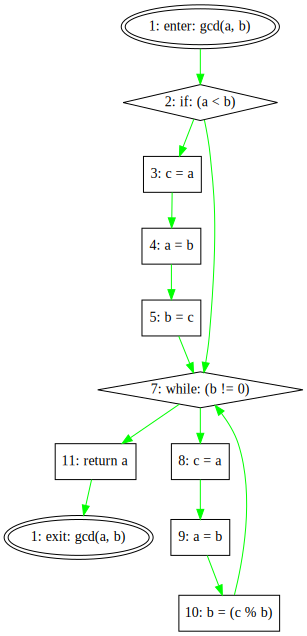

In [159]:
Source(to_graph(gen_cfg(inspect.getsource(gcd)), arcs=cov_to_arcs(cov)))

How do we make use of our fuzzer in practice? We explore a small case study of a program to solve the roots of a quadratic equation.

#### Example: roots
Here is the famous equation for finding the roots of quadratic equations.

In [160]:
def roots(a, b, c):
    d = b * b - 4 * a * c
    ax = 0.5 * d
    bx = 0
    while (ax - bx) > 0.1:
        bx = 0.5 * (ax + d / ax)
        ax = bx
    s = bx

    a2 = 2 * a
    ba2 = b / a2
    return -ba2 + s / a2, -ba2 - s / a2

Does the program look correct? Let us investigate if the program is reasonable. But before that, we need a helper
function `sym_to_float()` to convert symbolic values to floating point.

In [161]:
def sym_to_float(v):
    if v is None:
        return math.inf
    return v.numerator_as_long() / v.denominator_as_long()

Now we are ready to fuzz.

In [162]:
asymfz_roots = AdvancedSymbolicFuzzer(
    roots,
    max_tries=10,
    max_iter=10,
    max_depth=10,
    symbolic_fn='z3.Real')
with ExpectError():
    for i in range(100):
        r = asymfz_roots.fuzz()
        d = [sym_to_float(r[i]) for i in ['a', 'b', 'c']]
        v = roots(*d)
        print(d, v)

[0.5, 0.125, 1.0] (-0.125, -0.125)
[0.5, 0.125, 2.0] (-0.125, -0.125)
[0.5, 0.125, 3.0] (-0.125, -0.125)


Traceback (most recent call last):
  File "<ipython-input-162-f5ef2f568ed3>", line 11, in <module>
    v = roots(*d)
  File "<ipython-input-160-52eec1eb10b3>", line 11, in roots
    ba2 = b / a2
ZeroDivisionError: float division by zero (expected)


We have a `ZeroDivisionError`. Can we eliminate it?

#####  roots - take 2

In [163]:
def roots2(a, b, c):
    d = b * b - 4 * a * c

    xa = 0.5 * d
    xb = 0
    while (xa - xb) > 0.1:
        xb = 0.5 * (xa + d / xa)
        xa = xb
    s = xb

    if a == 0:
        return -c / b

    a2 = 2 * a
    ba2 = b / a2
    return -ba2 + s / a2, -ba2 - s / a2

In [164]:
asymfz_roots = AdvancedSymbolicFuzzer(
    roots2,
    max_tries=10,
    max_iter=10,
    max_depth=10,
    symbolic_fn='z3.Real')
with ExpectError():
    for i in range(1000):
        r = asymfz_roots.fuzz()
        d = [sym_to_float(r[i]) for i in ['a', 'b', 'c']]
        v = roots2(*d)
        #print(d, v)

Traceback (most recent call last):
  File "<ipython-input-164-bb7dc1496456>", line 11, in <module>
    v = roots2(*d)
  File "<ipython-input-163-0e6dcf0888e2>", line 12, in roots2
    return -c / b
ZeroDivisionError: float division by zero (expected)


Apparently, our fix was incomplete. Let us try again.

#####  roots - take 3

In [165]:
import math

In [166]:
def roots3(a, b, c):
    d = b * b - 4 * a * c

    xa = 0.5 * d
    xb = 0
    while (xa - xb) > 0.1:
        xb = 0.5 * (xa + d / xa)
        xa = xb
    s = xb

    if a == 0:
        if b == 0:
            return math.inf
        return -c / b

    a2 = 2 * a
    ba2 = b / a2
    return -ba2 + s / a2, -ba2 - s / a2

In [167]:
asymfz_roots = AdvancedSymbolicFuzzer(
    roots3,
    max_tries=10,
    max_iter=10,
    max_depth=10,
    symbolic_fn='z3.Real')
# with ExpectError():
for i in range(10):
    r = asymfz_roots.fuzz()
    print(r)
    d = [sym_to_float(r[i]) for i in ['a', 'b', 'c']]
    v = roots3(*d)
    print(d, v)

{'a': -1, 'b': 0, 'c': 0}
[-1.0, 0.0, 0.0] (0.0, 0.0)
{'a': -1/2, 'b': 0, 'c': 0}
[-0.5, 0.0, 0.0] (0.0, 0.0)
{'a': 0, 'b': 1/4, 'c': 0}
[0.0, 0.25, 0.0] -0.0
{'a': 0, 'b': 0, 'c': 1}
[0.0, 0.0, 1.0] inf
{'a': 1, 'b': 1/8, 'c': 1}
[1.0, 0.125, 1.0] (-0.0625, -0.0625)
{'a': 0, 'b': 1/4, 'c': -1}
[0.0, 0.25, -1.0] 4.0
{'a': 0, 'b': 0, 'c': 0}
[0.0, 0.0, 0.0] inf
{'a': -1, 'b': 0, 'c': -1}
[-1.0, 0.0, -1.0] (0.0, 0.0)
{'a': 0, 'b': 0, 'c': -1/2}
[0.0, 0.0, -0.5] inf
{'a': 0, 'b': 0, 'c': 1/8}
[0.0, 0.0, 0.125] inf


#### Problems with our advanced fuzzer

There is an evident error in this program. We are not checking for negative roots. However, the symbolic execution does not seem to have detected it.

Why are we not able to detect the problem of negative roots? Because we stop execution at a predetermined depth without throwing an error. That is, our symbolic execution is wide but shallow.

Is there a way to make it go deep? One solution is to go for the *Concolic Execution*.

### Concolic Execution

In *concolic execution*, we rely on a seed input to guide our symbolic execution. We collect the line numbers that our seed input traces, and feed it to the symbolic execution such that in the `explore` step, only the child node that correspond to the seed input execution path is chosen. This allows us to collect the complete set of constraints along a *representative path*. Once we have it, we can choose any particular predicate and invert it to explore the program execution paths near the representative path.

We modify our original `Tracer` to provide *all* line numbers that the program traversed.

#### ConcolicFuzzer

In [168]:
class Tracer(Tracer):
    def offsets_from_entry(self, fn):
        zero = self._trace[0][1] - 1
        return [l-zero for (f,l) in self._trace if f == fn]

In [169]:
with Tracer() as cov:
    roots3(1, 1, 1)

In [170]:
cov.offsets_from_entry('roots3')

[1, 2, 4, 5, 6, 9, 11, 16, 17, 18]

The `ConcolicFuzzer` first extracts the program trace on a seed input.

In [171]:
class ConcolicFuzzer(AdvancedSymbolicFuzzer):
    def __init__(self, fn, fnargs, **kwargs):
        with Tracer() as cov:
            fn(*fnargs)
        self.lines = cov.offsets_from_entry(fn.__name__)
        self.current_line = 0
        super().__init__(fn, **kwargs)

##### get_all_paths
The method `get_all_paths()` now tries to follow the seed execution path.

In [172]:
class ConcolicFuzzer(ConcolicFuzzer):
    def get_all_paths(self, fenter):
        assert fenter.ast_node.lineno == self.lines[self.current_line]
        self.current_line += 1
        last_node = PNode(0, fenter)
        while last_node and self.current_line < len(self.lines):
            if last_node.cfgnode.children:
                np = last_node.explore()
                for p in np:
                    if self.lines[self.current_line] == p.cfgnode.ast_node.lineno:
                        self.current_line += 1
                        last_node = p
                        break
                else:
                    last_node = None
                    break
            else:
                break
        assert len(self.lines) == self.current_line
        return [last_node]

    def solve_path_constraint(self, path):
        # re-initializing does not seem problematic.
        # a = z3.Int('a').get_id() remains the same.
        constraints = self.extract_constraints(path)
        exec(define_vars(used_vars(constraints), self.symbolic_fn))

        solutions = {}
        with checkpoint(self.z3):
            eval('self.z3.add(%s)' % ', '.join(constraints))
            if self.z3.check() != z3.sat:
                return {}
            m = self.z3.model()
            solutions = {d.name(): m[d] for d in m.decls()}
            my_args = {k: solutions.get(k, None) for k in self.fn_args}
        predicate = 'z3.And(%s)' % ','.join(
            ["%s == %s" % (k, v) for k, v in my_args.items()])
        eval('self.z3.add(z3.Not(%s))' % predicate)
        return my_args

#### Fuzzing with our concolic fuzzer

In [173]:
acfz_roots = ConcolicFuzzer(
    roots3,
    fnargs=[1, 1, 1],
    max_tries=10,
    max_iter=10,
    max_depth=10,
    symbolic_fn='z3.Real')

In [174]:
acfz_roots.paths[0].get_path_to_root()

[PNode:0[id:62 line[1] parents: [] : enter: roots3(a, b, c) order:0],
 PNode:1[id:64 line[2] parents: [62] : d = ((b * b) - ((4 * a) * c)) order:0],
 PNode:2[id:65 line[4] parents: [64] : xa = (0.5 * d) order:0],
 PNode:3[id:66 line[5] parents: [65] : xb = 0 order:0],
 PNode:4[id:67 line[6] parents: [66, 69] : _while: ((xa - xb) > 0.1) order:1],
 PNode:5[id:70 line[9] parents: [67] : s = xb order:0],
 PNode:6[id:71 line[11] parents: [70] : _if: (a == 0) order:1],
 PNode:7[id:75 line[16] parents: [71] : a2 = (2 * a) order:0],
 PNode:8[id:76 line[17] parents: [75] : ba2 = (b / a2) order:0],
 PNode:9[id:77 line[18] parents: [76] : return (((- ba2) + (s / a2)), ((- ba2) - (s / a2))) order:0]]

In [175]:
print([i.cfgnode.ast_node.lineno for i in acfz_roots.paths[0].get_path_to_root()])
print(acfz_roots.lines)

[1, 2, 4, 5, 6, 9, 11, 16, 17, 18]
[1, 2, 4, 5, 6, 9, 11, 16, 17, 18]


We extract the constraints as usual.

In [176]:
constraints = acfz_roots.extract_constraints(
    acfz_roots.paths[0].get_path_to_root())

In [177]:
constraints

['z3.And((a == _a_0), (b == _b_0), (c == _c_0))',
 '(_d_0 == ((_b_0 * _b_0) - ((4 * _a_0) * _c_0)))',
 '(_xa_0 == (0.5 * _d_0))',
 '(_xb_0 == 0)',
 'z3.Not(((_xa_0 - _xb_0) > 0.1))',
 '(_s_0 == _xb_0)',
 'z3.Not((_a_0 == 0))',
 '(_a2_0 == (2 * _a_0))',
 '(_ba2_0 == (_b_0 / _a2_0))']

The used vars are first as symbolic.

In [178]:
exec(define_vars(used_vars(constraints), 'z3.Real'))

We can now solve our constraints. However, before that, here is a question for you.

Should it result in exactly the same arguments?

In [179]:
eval('z3.solve(%s)' % ','.join(constraints))

[_b_0 = 1/8,
 _a_0 = 1,
 _c_0 = 1,
 _ba2_0 = 1/16,
 _a2_0 = 2,
 _s_0 = 0,
 _xb_0 = 0,
 _xa_0 = -255/128,
 _d_0 = -255/64,
 c = 1,
 b = 1/8,
 a = 1]


In [180]:
acfz_roots.fuzz()

{'a': 1, 'b': 0, 'c': 0}

Did they take the same path?

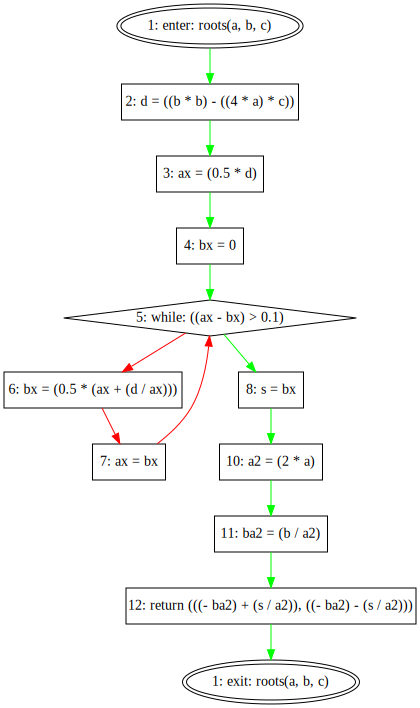

In [181]:
with Tracer() as cov:
    roots(1, 1, 1)
Source(to_graph(gen_cfg(inspect.getsource(roots)), arcs=cov_to_arcs(cov)))

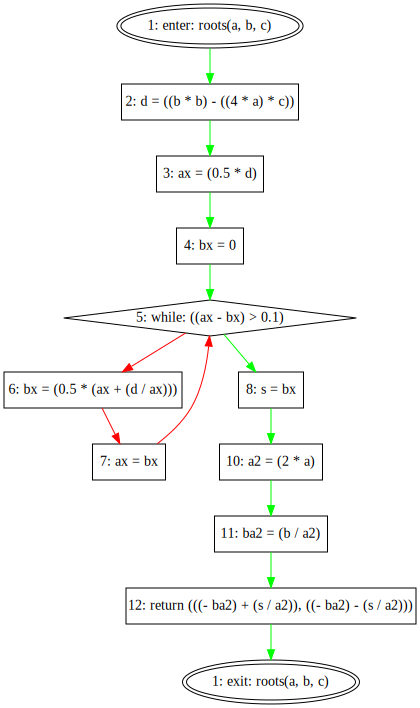

In [182]:
with Tracer() as cov:
    roots(1, 1 / 8, 1)
Source(to_graph(gen_cfg(inspect.getsource(roots)), arcs=cov_to_arcs(cov)))

Remember our constraints

In [183]:
constraints

['z3.And((a == _a_0), (b == _b_0), (c == _c_0))',
 '(_d_0 == ((_b_0 * _b_0) - ((4 * _a_0) * _c_0)))',
 '(_xa_0 == (0.5 * _d_0))',
 '(_xb_0 == 0)',
 'z3.Not(((_xa_0 - _xb_0) > 0.1))',
 '(_s_0 == _xb_0)',
 'z3.Not((_a_0 == 0))',
 '(_a2_0 == (2 * _a_0))',
 '(_ba2_0 == (_b_0 / _a2_0))']

#### Exploring nearby paths

We can explore nearby paths by negating some of the predicates.

In [184]:
new_constraints = constraints[0:4] + ['z3.Not(%s)' % constraints[4]]

In [185]:
new_constraints

['z3.And((a == _a_0), (b == _b_0), (c == _c_0))',
 '(_d_0 == ((_b_0 * _b_0) - ((4 * _a_0) * _c_0)))',
 '(_xa_0 == (0.5 * _d_0))',
 '(_xb_0 == 0)',
 'z3.Not(z3.Not(((_xa_0 - _xb_0) > 0.1)))']

In [186]:
eval('z3.solve(%s)' % ','.join(new_constraints))

[_b_0 = 0,
 _c_0 = 1,
 _a_0 = -11/20,
 _xb_0 = 0,
 _xa_0 = 11/10,
 _d_0 = 11/5,
 c = 1,
 b = 0,
 a = -11/20]


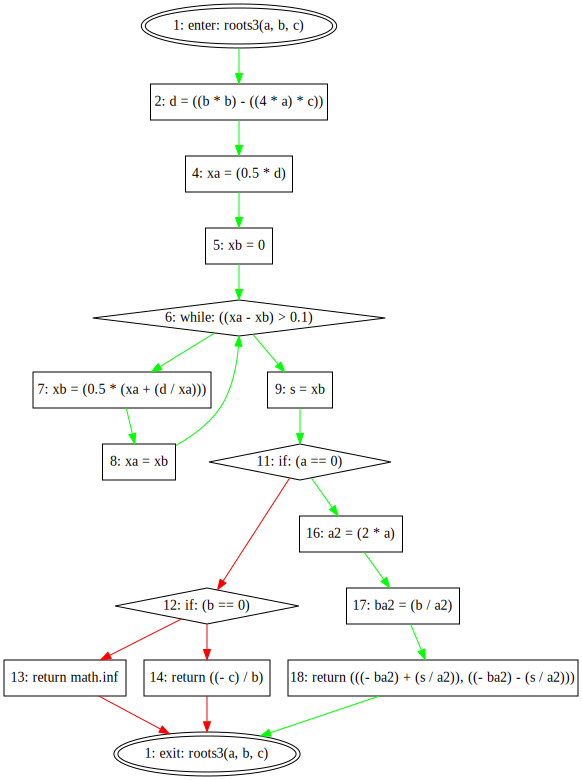

In [187]:
with Tracer() as cov:
    roots3(1, 0, -11 / 20)
Source(to_graph(gen_cfg(inspect.getsource(roots3)), arcs=cov_to_arcs(cov)))

\todo{Function summaries and variable renaming}

Our symbolic fuzzer is reasonable for single functions that use `Int` or `Real` values. However, real world applications often contain multiple recursive method calls, which will not be handled by our implementation. Nor are real applications restricted to using just numbers.

We will examine an implementation that can handle practical programs next.

### Concolic Execution with Proxies

A second approach to concolic execution is to use a wrapper class as we did in the [chapter on information flow](InformationFlow.ipynb). We start with a register for symbolic variables.

In [188]:
Var_Register = {}

Next, we define wrapper objects for concolic variables.

#### IntWrapper

In [189]:
class IntWrapper():
    def __init__(self, z, value=None):
        self.z = z
        self.value = value
        Var_Register[z.sexpr()] = z

    def __add__(self, other):
        return IntWrapper(self.z + other.z, self.value + other.value)

    def __radd__(self, other):
        return self.__add__(other)

    def __eq__(self, other):
        if isinstance(other, int):
            return BoolWrapper(self.z == other, self.value == other)
        else:
            return BoolWrapper(self.z == other.z, self.value == other.value)

    def __lt__(self, other):
        if isinstance(other, int):
            return BoolWrapper(self.z < other, self.value < other)
        else:
            return BoolWrapper(self.z < other.z, self.value < other.value)

    def __gt__(self, other):
        if isinstance(other, int):
            return BoolWrapper(self.z > other, self.value > other)
        else:
            return BoolWrapper(self.z > other.z, self.value > other.value)

    def __req__(self, other):
        return self.__eq__(other)

#### BoolWrapper

The `BoolWrapper` collects the predicates that it finds along the way.

In [190]:
Predicates = []

In [191]:
class BoolWrapper():
    def __init__(self, z, value=None):
        self.z = z
        self.value = value

    def __not__(self):
        return BoolWrapper(z3.Not(self.z), not self.value)

    def __bool__(self):
        if self.value:
            Predicates.append(self.z)
            return True
        else:
            Predicates.append(z3.Not(self.z))
            return False

Finally the `explore()` function executes the given function returns the result and predicates collected along the way.

In [192]:
def explore(fn, args):
    result, error = None, None
    Predicates.clear()
    Var_Register.clear()
    my_args = []
    for i,a in enumerate(args):
        if isinstance(a, int):
            my_args.append(IntWrapper(z3.Int('arg_%s' % i), a))
        else:
            assert False
    try:
        result = fn(*my_args)
    except Exception as e:
        error = e
    finally:
        return (result, error, Predicates)

Let us see if this works.

In [193]:
result, err, pred = explore(abs_max, [2, 1])

In [194]:
pred

[Not(arg_0 < 0), Not(arg_1 < 0), arg_0 > arg_1]

In [195]:
for k in Var_Register:
    s = "%s=z3.Int('%s')" % (k, Var_Register[k])
    print(s)
    exec(s)

arg_0=z3.Int('arg_0')
arg_1=z3.Int('arg_1')


In [196]:
z3.solve(pred)

[arg_1 = 0, arg_0 = 1]


## Concolic Execution with PyExZ3

 **Requires the PyExZ3 pip package from [here](https://github.com/uds-se/PyExZ3).**
 
[PyExZ3](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/dse.pdf) is a concolic evaluator of programs that takes a different strategy from what we did here. Similar to our dynamic taint approach, the PyExZ3 wraps the Python data structures so that they are symbolic equivalents. These data structures are then traced through program execution, and constraints are collected at the end.

```python
import PyExZ3.pyloader
import symbolic.symbolic_types as st
```

```python
generatedInputs, returnVals, path = PyExZ3.pyloader.exploreFunction(check_triangle)
```

We can get *PyExZ3* to print a flow graph of the conditions it examined.

```python
Source(path.toDot())
```

As in our implementation, *PyExZ3* also takes a `max_iters` argument.

```python
generatedInputs, returnVals, path = PyExZ3.pyloader.exploreFunction(gcd, max_iters=5)
```

```python
Source(path.toDot())
```

This is useful in functions such as `factorial()`.

In [197]:
def factorial(n):
    if n <= 1:
        return 1
    return n * factorial(n - 1)

```python
generatedInputs, returnVals, path = PyExZ3.pyloader.exploreFunction(factorial, max_iters=10)
```

Our implementation did not yet implement symbolic execution through function calls. *PyExZ3* does handle symbolic execution across function boundaries.

In [198]:
import math

In [199]:
def discriminant(a, b, c):
    return b * b - 4 * a * c

In [200]:
def my_roots(a, b, c):
    if a == 0:
        if b == 0:
            return math.inf
        return -c / b
    d = discriminant(a, b, c)
    a2 = 2 * a
    ba2 = b / a2
    if d == 0:
        return -ba2
    s = math.sqrt(d)
    return -ba2 + s / a2, -ba2 - s / a2

Remember what we mentioned about our implementation being unable to determine the error of the previous `roots()`? Would *PyExZ3* find it?

```python
generatedInputs, returnVals, path = PyExZ3.pyloader.exploreFunction(my_roots)
```

Unfortunately, it does not seem to detect it. The culprit is the `math.sqrt()` call. *PyExZ3* does not know how it behaves. Hence, it makes the returned variable unconstrained. It can be seen when we try to trace the function directly.

```python
with ExpectError():
    generatedInputs, returnVals, path = PyExZ3.pyloader.exploreFunction(math.sqrt)
```

The problem here is that *PyExZ3* does not know about *math.sqrt*. Can we help it?

In [201]:
def sqrt(d):
    if d < 0:
        assert False
    xa = 0.5 * d
    xb = 0
    while (xa - xb) > 0.1:
        xb = 0.5 * (xa + d / xa)
        xa = xb
    s = xb
    return s

In [202]:
def discriminant(a, b, c):
    return b * b - 4 * a * c

In [203]:
def my_roots(a, b, c):
    if a == 0:
        if b == 0:
            return math.inf
        return -c / b
    d = discriminant(a, b, c)
    a2 = 2 * a
    ba2 = b / a2
    if d == 0:
        return -ba2
    s = sqrt(d)
    return -ba2 + s / a2, -ba2 - s / a2

With this, *PyExZ3* is ready to find all the problematic areas.

```python
with ExpectError():
    generatedInputs, returnVals, path = PyExZ3.pyloader.exploreFunction(my_roots, max_iters=1000)
```

#### roots - take 4

In [204]:
def sqrt(d):
    if d < 0:
        assert False
    xa = 0.5 * d
    xb = 0
    while (xa - xb) > 0.1:
        xb = 0.5 * (xa + d / xa)
        xa = xb
    s = xb
    return s

In [205]:
def discriminant(a, b, c):
    return b * b - 4 * a * c

In [206]:
def roots4(a, b, c):
    if a == 0:
        if b == 0:
            return math.inf
        return -c / b
    d = discriminant(a, b, c)
    a2 = 2 * a
    ba2 = b / a2
    if d == 0:
        return -ba2
    elif d < 0:
        s = sqrt(-d)
        return (-ba2, s / a2), (-ba2, -s / a2)
    else:
        s = sqrt(d)
        return -ba2 + s / a2, -ba2 - s / a2

And that indeed seems to be accepted by *PyExZ3*.

```python
generatedInputs, returnVals, path = PyExZ3.pyloader.exploreFunction(roots4, max_iters=1000)
```

## Using Concolic Execution in Fuzzing

Similar to dynamic taint analysis, one can consider *concolic execution* as a better oracle for fuzzing. For dynamic taints, we simply check whether taints reached any of the marked sinks on fuzzing, which helps us to not rely only on program crashes to detect that a program has vulnerabilities. Similarly, *concolic execution* needs to be driven by grammar based deep fuzzing, and the end result can be checked for specific properties such as information leak.\todo{Expand}.

## Lessons Learned

* One can use symbolic execution to augment the inputs that explore all characteristics of a program.
* Symbolic execution can be broad but shallow.
* Concolic execution provides an acceptable middle ground, and uses a seed execution for guiding the symbolic exploration.

## Next Steps

* [Search based fuzzing](SearchBasedFuzzer.ipynb) can often be an acceptable middle ground when random fuzzing does not provide sufficient results, but symbolic fuzzing is too heavyweight.

## Background

Symbolic execution of programs was originally described by King~\cite{king1976symbolic} in 1976. It is used extensively in vulnerability analysis of software, especially binary programs. Some of the well known symbolic execution tools include KLEE~\cite{KLEE}, Angr~\cite{wang2017angr, stephens2016driller}, and SAGE~\cite{godefroid2012sage}. The most well known symbolic execution environment for Python is CHEF~\cite{bucur2014prototyping} which does symbolic execution by modifying the interpreter. PeerCheck~\cite{PeerCheck} and PEF~\cite{PEF} are two concolic execution engines.

## Exercises

### Exercise 1: _Extending Symbolic Fuzzer to use function summaries_

We showed in the first section how function summaries may be produced. Can you extend the `AdvancedSymbolicFuzzer` to use function summaries when needed?

**Solution.** _None yet available._

### Exercise 2: _Inferring variable types for Concolic Fuzzer_

Our `ConcolicFuzzer` assumes that all its variables are of the same category. However, most real world programs take inputs with different data types, and different data types are used during execution. Given that Python is a dynamic language, how do we know what to declare our variables as? One way (the simplest) is to rely on the types returned by the concrete execution. Can you modify our `ConcolicFuzzer` so that it uses the right variable types?

**Solution.** _None yet available._

### Exercise 3: _Extending Concolic Fuzzer to trace through function calls_

Unlike SymbolicFuzzers, a ConcolicFuzzer does not need function summaries. In fact, it needs to step through individual steps of functions it can get access to (For external functions such as `math.sqrt`, one still has to rely on function summaries). Can you extend the `ConcolicFuzzer` to trace across function boundaries?

**Solution.** _None yet available._